# Cox_FM_PH_model1：Cox PH と Flow による校正（PH 診断と Cox+Flow(tt) の比較）

## 概要
- 目的：比例ハザード（PH）の破れを，Cox の解釈可能パラメータを保ったまま Flow 側で吸収し，校正改善を確認します．
- 内容：R（survival 等）で Cox と PH 診断を行い，Python 側の流れ（FM）で補正した予測リスクの calibration を比較します．
- 実行：上から順に実行（Run All）してください（rpy2 により R を呼びます）．
- 依存：Python 側は rpy2；R 側は survival, riskRegression, prodlim（環境によっては cancer も）．
- 出力：PH の要約表，calibration curve（図）など．

## 実行メモ
- 乱数性があります（seed を固定したい場合は冒頭セルで設定してください）．
- 実行環境：Python 3 系（推奨：3.10+）．GPU は任意です．


In [1]:
!pip -q install rpy2
%load_ext rpy2.ipython


In [2]:
%%R
options(repos="https://cloud.r-project.org")
pkgs <- c("survival","riskRegression","prodlim")
to_install <- pkgs[!sapply(pkgs, requireNamespace, quietly=TRUE)]
if (length(to_install)>0) install.packages(to_install)
lapply(pkgs, library, character.only=TRUE)

# status の符号がデータセットごとに微妙に違うので，それっぽく吸収
make_event01 <- function(status){
  u <- sort(unique(na.omit(status)))
  # よくある: 0/1, 1/2, 0/1/2
  if (all(u %in% c(0,1))) return(as.integer(status==1))
  if (all(u %in% c(1,2))) return(as.integer(status==2))
  # それ以外は最大値を event とみなす（保険）
  return(as.integer(status==max(u)))
}

# Cox + PH診断 + Cox+Flow(tt) + 予測差 + Score(校正/Brier/AUC) を一括実行
run_one <- function(df, time_col, status_col, x_formula, name="data"){
  df <- df[, c(time_col, status_col, all.vars(x_formula)), drop=FALSE]
  df <- na.omit(df)

  df$time  <- df[[time_col]]
  df$event <- make_event01(df[[status_col]])

  set.seed(1)
  n <- nrow(df)
  idx <- sample.int(n, size=floor(0.7*n))
  train <- df[idx,]
  test  <- df[-idx,]

  # baseline Cox
  f0 <- as.formula(paste0("Surv(time,event) ~ ", deparse(x_formula)))
  fit0 <- coxph(f0, data=train, x=TRUE, y=TRUE)

  # PH 診断（どの変数が破りやすいか）
  zph <- cox.zph(fit0, transform="km")
  ptab <- zph$table
  # GLOBAL を除いた最小 p の共変量を Flow 対象にする
  pvec <- ptab[rownames(ptab)!="GLOBAL", "p"]
  tv_var <- names(which.min(pvec))

  cat("\n========================\n")
  cat("Dataset:", name, "\n")
  cat("PH global p =", ptab["GLOBAL","p"], "\n")
  cat("Worst PH var =", tv_var, " (p=", ptab[tv_var,"p"], ")\n")

  # Cox+Flow: beta(t)=beta0 + beta1 log t を最小実装
  # 既に tv_var は f0 に入っているので，tt(tv_var) を足すだけ
  f1 <- update(f0, as.formula(paste0(". ~ . + tt(", tv_var, ")")))
  fit1 <- coxph(f1, data=train, x=TRUE, y=TRUE,
                tt=function(x,t,...) x*log(pmax(t,1e-6)))

  # 評価時点（テストのイベント時刻の分位点）
  te <- test$time[test$event==1]
  times <- as.numeric(quantile(te, probs=c(0.25,0.5,0.75)))
  times <- sort(unique(times))

  # 予測差（PH 良いと小さくなるはず）
  r0 <- predictRisk(fit0, newdata=test, times=times)
  r1 <- predictRisk(fit1, newdata=test, times=times)
  diff_mean <- colMeans(abs(r1-r0))
  cat("Mean |risk_flow - risk_cox| at times:\n")
  print(data.frame(time=times, mean_abs_diff=diff_mean))

  # riskRegression::Score で Brier/AUC/校正を同じ枠で比較
  sc <- Score(list(Cox=fit0, CoxFlow=fit1),
              formula=Surv(time,event)~1,
              data=test,
              times=times,
              metrics=c("Brier","AUC"),
              plots="cal")
  print(sc)
  list(train=train, test=test, fit0=fit0, fit1=fit1, zph=zph, times=times, Score=sc, tv_var=tv_var)
}


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘listenv’, ‘parallelly’, ‘zoo’, ‘future’, ‘globals’, ‘TH.data’, ‘sandwich’, ‘gridExtra’, ‘Formula’, ‘MatrixModels’, ‘checkmate’, ‘iterators’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘multcomp’, ‘RcppEigen’, ‘Hmisc’, ‘quantreg’, ‘SparseM’, ‘polspline’, ‘htmlTable’, ‘colorspace’, ‘shape’, ‘cmprsk’, ‘doParallel’, ‘foreach’, ‘lava’, ‘mets’, ‘mvtnorm’, ‘plotrix’, ‘Publish’, ‘ranger’, ‘rms’, ‘glmnet’, ‘timereg’, ‘RcppArmadillo’, ‘diagram’

trying URL 'https://cloud.r-project.org/src/contrib/listenv_0.10.0.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/parallelly_1.46.1.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/zoo_1.8-15.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/future_1.69.0.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/globals_0.18.0.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/TH.data_1

In [4]:
%%R
library(survival)

lung    <- survival::lung
pbc     <- survival::pbc

# veteran が survival 側で見つからない場合があるので保険
veteran <- tryCatch(survival::veteran, error=function(e) NULL)
if (is.null(veteran)) {
  # もし cancer パッケージにある環境ならこちら（無ければ別データに差し替え）
  if (!requireNamespace("cancer", quietly=TRUE)) install.packages("cancer")
  veteran <- cancer::veteran
}

head(lung); head(pbc); head(veteran)


  trt celltype time status karno diagtime age prior
1   1 squamous   72      1    60        7  69     0
2   1 squamous  411      1    70        5  64    10
3   1 squamous  228      1    60        3  38     0
4   1 squamous  126      1    60        9  63    10
5   1 squamous  118      1    70       11  65    10
6   1 squamous   10      1    20        5  49     0


In [5]:
%%R
library(survival)

make_event01 <- function(status){
  u <- sort(unique(na.omit(status)))
  if (all(u %in% c(0,1))) return(as.integer(status==1))
  if (all(u %in% c(1,2))) return(as.integer(status==2))
  return(as.integer(status==max(u)))
}

run_one <- function(df, time_col, status_col, x_formula, name="data"){
  # x_formula は「~ age + sex + ...」の形を想定
  rhs <- paste(deparse(x_formula), collapse="")
  rhs <- sub("^~\\s*", "", rhs)   # 先頭の "~" を除去（ここが修正点）

  # 必要列だけ抜く
  df <- df[, c(time_col, status_col, all.vars(as.formula(paste("~", rhs)))), drop=FALSE]
  df <- na.omit(df)

  df$time  <- df[[time_col]]
  df$event <- make_event01(df[[status_col]])

  set.seed(1)
  n <- nrow(df)
  idx <- sample.int(n, size=floor(0.7*n))
  train <- df[idx,]
  test  <- df[-idx,]

  f0 <- as.formula(paste0("Surv(time,event) ~ ", rhs))
  fit0 <- coxph(f0, data=train, x=TRUE, y=TRUE)

  zph <- cox.zph(fit0, transform="km")
  ptab <- zph$table
  pvec <- ptab[rownames(ptab)!="GLOBAL", "p"]
  tv_var <- names(which.min(pvec))

  cat("\n========================\n")
  cat("Dataset:", name, "\n")
  cat("PH global p =", ptab["GLOBAL","p"], "\n")
  cat("Worst PH var =", tv_var, " (p=", ptab[tv_var,"p"], ")\n")

  # 最小の Cox+Flow：beta(t)=beta0 + beta1 log t（tt項）
  f1 <- update(f0, as.formula(paste0(". ~ . + tt(", tv_var, ")")))
  fit1 <- coxph(f1, data=train, x=TRUE, y=TRUE,
                tt=function(x,t,...) x*log(pmax(t,1e-6)))

  te <- test$time[test$event==1]
  times <- as.numeric(quantile(te, probs=c(0.25,0.5,0.75)))
  times <- sort(unique(times))

  # 予測リスク差
  r0 <- predictRisk(fit0, newdata=test, times=times)
  r1 <- predictRisk(fit1, newdata=test, times=times)
  diff_mean <- colMeans(abs(r1-r0))
  cat("Mean |risk_flow - risk_cox|:\n")
  print(data.frame(time=times, mean_abs_diff=diff_mean))

  list(train=train, test=test, fit0=fit0, fit1=fit1, zph=zph, times=times, tv_var=tv_var)
}


In [7]:
%%R
library(survival)

make_event01 <- function(status){
  u <- sort(unique(na.omit(status)))
  if (all(u %in% c(0,1))) return(as.integer(status==1))
  if (all(u %in% c(1,2))) return(as.integer(status==2))
  return(as.integer(status==max(u)))
}

# Cox の予測リスク：P(T<=t | x) を返す（times ベクトル対応）
predict_risk_cox_const <- function(fit, newdata, times){
  bh <- basehaz(fit, centered=FALSE)
  idx <- findInterval(times, bh$time)
  H0  <- ifelse(idx==0, 0, bh$hazard[idx])

  lp  <- as.numeric(predict(fit, newdata=newdata, type="lp"))
  # risk = 1 - exp( - H0(t) * exp(lp) )
  out <- sapply(seq_along(times), function(j){
    1 - exp(-H0[j] * exp(lp))
  })
  colnames(out) <- paste0("t", times)
  out
}

# tt(x,t)= x*log(t)（数値 x）の Cox+Flow 予測リスク
predict_risk_tt_log_numeric <- function(fit, f0, tv_var, newdata, times){
  # baseline hazard increments
  bh <- basehaz(fit, centered=FALSE)
  tgrid <- pmax(bh$time, 1e-12)
  dH0 <- diff(c(0, bh$hazard))   # ΔH0 at each event time

  # 係数分解：beta（一定）と gamma（tt項）
  cn <- names(coef(fit))
  gname <- paste0("tt(", tv_var, ")")
  if (!(gname %in% cn)) stop("tt coefficient name not found: ", gname)

  gamma <- as.numeric(coef(fit)[gname])
  beta_names <- setdiff(cn, gname)

  # 一定部分の線形予測：X beta
  tt_rhs <- delete.response(terms(f0))
  X <- model.matrix(tt_rhs, newdata)
  if ("(Intercept)" %in% colnames(X)) X <- X[, colnames(X)!="(Intercept)", drop=FALSE]
  # fit 側にある列だけに合わせる
  X <- X[, beta_names, drop=FALSE]
  lp0 <- as.numeric(X %*% coef(fit)[beta_names])

  # z_i = gamma * x_i（時間依存の強さ）
  x_tv <- as.numeric(newdata[[tv_var]])
  z <- gamma * x_tv

  # times ごとに cumhaz を計算（outer で一括）
  out <- sapply(times, function(t0){
    m <- findInterval(t0, tgrid)
    if (m==0) return(rep(0, nrow(newdata)))

    tg <- tgrid[1:m]
    wg <- dH0[1:m]

    # n x m 行列：exp(z_i * log(tg_k))
    M <- exp(outer(z, log(tg)))
    # 各行で Σ wg_k * M_ik
    A <- as.numeric(M %*% wg)

    # cumhaz = exp(lp0) * A
    ch <- exp(lp0) * A
    1 - exp(-ch)
  })
  colnames(out) <- paste0("t", times)
  out
}

run_one <- function(df, time_col, status_col, x_formula, name="data"){
  rhs <- paste(deparse(x_formula), collapse="")
  rhs <- sub("^~\\s*", "", rhs)

  df <- df[, c(time_col, status_col, all.vars(as.formula(paste("~", rhs)))), drop=FALSE]
  df <- na.omit(df)
  df$time  <- df[[time_col]]
  df$event <- make_event01(df[[status_col]])

  set.seed(1)
  n <- nrow(df)
  idx <- sample.int(n, size=floor(0.7*n))
  train <- df[idx,]
  test  <- df[-idx,]

  f0 <- as.formula(paste0("Surv(time,event) ~ ", rhs))
  fit0 <- coxph(f0, data=train, x=TRUE, y=TRUE)

  zph <- cox.zph(fit0, transform="km")
  ptab <- zph$table
  pvec <- ptab[rownames(ptab)!="GLOBAL", "p"]

  # tt に入れるのは「数値変数」から選ぶ（ここが重要）
  cand <- intersect(names(pvec), names(train))
  cand <- cand[sapply(cand, function(v) is.numeric(train[[v]]))]
  if (length(cand)==0) stop("No numeric covariate available for tt().")
  tv_var <- cand[which.min(pvec[cand])]

  cat("\n========================\n")
  cat("Dataset:", name, "\n")
  cat("PH global p =", ptab["GLOBAL","p"], "\n")
  cat("Worst PH numeric var =", tv_var, " (p=", pvec[tv_var], ")\n")

  # Cox+Flow（tt）
  f1 <- update(f0, as.formula(paste0(". ~ . + tt(", tv_var, ")")))
  fit1 <- coxph(f1, data=train, x=TRUE, y=TRUE,
                tt=function(x,t,...) x*log(pmax(t,1e-12)))

  # 評価時点
  te <- test$time[test$event==1]
  times <- as.numeric(quantile(te, probs=c(0.25,0.5,0.75)))
  times <- sort(unique(times))

  # 予測リスク（自前）
  r0 <- predict_risk_cox_const(fit0, test, times)                 # n x |times|
  r1 <- predict_risk_tt_log_numeric(fit1, f0, tv_var, test, times) # n x |times|

  diff_mean <- colMeans(abs(r1-r0))
  cat("Mean |risk_flow - risk_cox|:\n")
  print(data.frame(time=times, mean_abs_diff=diff_mean))

  list(train=train, test=test, fit0=fit0, fit1=fit1, zph=zph, times=times, tv_var=tv_var,
       r0=r0, r1=r1)
}


In [9]:
%%R
library(survival)

make_event01 <- function(status){
  u <- sort(unique(na.omit(status)))
  if (all(u %in% c(0,1))) return(as.integer(status==1))
  if (all(u %in% c(1,2))) return(as.integer(status==2))
  return(as.integer(status==max(u)))
}

# Breslow 増分（一定係数 Cox）
breslow_const <- function(fit, train){
  tgrid <- sort(unique(train$time[train$event==1]))
  dk <- vapply(tgrid, function(t) sum(train$event==1 & train$time==t), numeric(1))

  lp_tr <- as.numeric(predict(fit, newdata=train, type="lp"))
  exp_lp_tr <- exp(lp_tr)

  risk_sum <- vapply(tgrid, function(t){
    sum(exp_lp_tr[train$time >= t])
  }, numeric(1))

  dH0 <- dk / pmax(risk_sum, 1e-12)
  list(tgrid=tgrid, dH0=dH0)
}

predict_risk_const <- function(fit, bh, newdata, times){
  lp <- as.numeric(predict(fit, newdata=newdata, type="lp"))
  exp_lp <- exp(lp)

  tgrid <- bh$tgrid
  dH0   <- bh$dH0

  out <- sapply(times, function(t0){
    m <- findInterval(t0, tgrid)
    H0 <- if (m==0) 0 else sum(dH0[1:m])
    1 - exp(-exp_lp * H0)
  })
  colnames(out) <- paste0("t", times)
  out
}

# Breslow 増分（tt(x,t)=x*log t の Cox+Flow）
breslow_tt_log <- function(fit0, fit1, tv_var, train){
  # 係数
  cn <- names(coef(fit1))
  gname <- paste0("tt(", tv_var, ")")
  if (!(gname %in% cn)) stop("tt coefficient name not found: ", gname)

  gamma <- as.numeric(coef(fit1)[gname])

  # baseline 部分の設計行列は fit0 を使う（因子レベルの整合が取れる）
  Xtr <- model.matrix(fit0, data=train)
  beta_names <- intersect(colnames(Xtr), names(coef(fit1)))
  lp0_tr <- as.numeric(Xtr[, beta_names, drop=FALSE] %*% coef(fit1)[beta_names])

  x_tv <- as.numeric(train[[tv_var]])
  z_tr <- gamma * x_tv

  tgrid <- sort(unique(train$time[train$event==1]))
  dk <- vapply(tgrid, function(t) sum(train$event==1 & train$time==t), numeric(1))

  risk_sum <- vapply(tgrid, function(t){
    at_risk <- (train$time >= t)
    sum(exp(lp0_tr[at_risk] + z_tr[at_risk]*log(pmax(t,1e-12))))
  }, numeric(1))

  dH0 <- dk / pmax(risk_sum, 1e-12)
  list(tgrid=tgrid, dH0=dH0, gamma=gamma, beta_names=beta_names)
}

predict_risk_tt_log <- function(fit0, fit1, bh_tt, tv_var, newdata, times){
  Xnew <- model.matrix(fit0, newdata=newdata)
  beta_names <- bh_tt$beta_names
  lp0_new <- as.numeric(Xnew[, beta_names, drop=FALSE] %*% coef(fit1)[beta_names])

  z_new <- bh_tt$gamma * as.numeric(newdata[[tv_var]])

  tgrid <- bh_tt$tgrid
  dH0   <- bh_tt$dH0
  logt  <- log(pmax(tgrid, 1e-12))

  out <- sapply(times, function(t0){
    m <- findInterval(t0, tgrid)
    if (m==0) return(rep(0, nrow(newdata)))

    w <- dH0[1:m]
    lt <- logt[1:m]
    # H_i(t0)=exp(lp0_i)* Σ_k w_k * exp(z_i * lt_k)
    A <- as.numeric(exp(outer(z_new, lt)) %*% w)
    H <- exp(lp0_new) * A
    1 - exp(-H)
  })
  colnames(out) <- paste0("t", times)
  out
}

run_one <- function(df, time_col, status_col, x_formula, name="data"){
  rhs <- paste(deparse(x_formula), collapse="")
  rhs <- sub("^~\\s*", "", rhs)

  df <- df[, c(time_col, status_col, all.vars(as.formula(paste("~", rhs)))), drop=FALSE]
  df <- na.omit(df)
  df$time  <- df[[time_col]]
  df$event <- make_event01(df[[status_col]])

  set.seed(1)
  n <- nrow(df)
  idx <- sample.int(n, size=floor(0.7*n))
  train <- df[idx,]
  test  <- df[-idx,]

  f0 <- as.formula(paste0("Surv(time,event) ~ ", rhs))
  fit0 <- coxph(f0, data=train, x=TRUE, y=TRUE)

  zph <- cox.zph(fit0, transform="km")
  ptab <- zph$table
  pvec <- ptab[rownames(ptab)!="GLOBAL", "p"]

  # tt は数値変数のみから選ぶ（因子に tt は入れない）
  cand <- intersect(names(pvec), names(train))
  cand <- cand[sapply(cand, function(v) is.numeric(train[[v]]))]
  if (length(cand)==0) stop("No numeric covariate available for tt().")
  tv_var <- cand[which.min(pvec[cand])]

  cat("\n========================\n")
  cat("Dataset:", name, "\n")
  cat("PH global p =", ptab["GLOBAL","p"], "\n")
  cat("Worst PH numeric var =", tv_var, " (p=", pvec[tv_var], ")\n")

  # Cox+Flow（tt）
  f1 <- update(f0, as.formula(paste0(". ~ . + tt(", tv_var, ")")))
  fit1 <- coxph(f1, data=train, x=TRUE, y=TRUE,
                tt=function(x,t,...) x*log(pmax(t,1e-12)))

  te <- test$time[test$event==1]
  times <- as.numeric(quantile(te, probs=c(0.25,0.5,0.75)))
  times <- sort(unique(times))

  # 予測（手計算 Breslow）
  bh0  <- breslow_const(fit0, train)
  r0   <- predict_risk_const(fit0, bh0, test, times)

  bh1  <- breslow_tt_log(fit0, fit1, tv_var, train)
  r1   <- predict_risk_tt_log(fit0, fit1, bh1, tv_var, test, times)

  diff_mean <- colMeans(abs(r1-r0))
  cat("Mean |risk_flow - risk_cox|:\n")
  print(data.frame(time=times, mean_abs_diff=diff_mean))

  list(train=train, test=test, fit0=fit0, fit1=fit1, zph=zph, times=times, tv_var=tv_var,
       r0=r0, r1=r1)
}


In [11]:
%%R
predict_risk_tt_log <- function(fit0, fit1, bh_tt, tv_var, newdata, times){
  # ★ここが修正点：data= を使う
  Xnew <- model.matrix(fit0, data=newdata)

  beta_names <- bh_tt$beta_names
  if (length(beta_names)==0){
    lp0_new <- rep(0, nrow(Xnew))
  } else {
    lp0_new <- as.numeric(Xnew[, beta_names, drop=FALSE] %*% coef(fit1)[beta_names])
  }

  z_new <- bh_tt$gamma * as.numeric(newdata[[tv_var]])

  tgrid <- bh_tt$tgrid
  dH0   <- bh_tt$dH0
  logt  <- log(pmax(tgrid, 1e-12))

  n <- nrow(Xnew)

  out <- sapply(times, function(t0){
    m <- findInterval(t0, tgrid)
    if (m==0) return(rep(0, n))

    w  <- dH0[1:m]
    lt <- logt[1:m]

    # A_i = Σ_k w_k * exp(z_i * lt_k)
    M <- exp(outer(z_new, lt))             # n x m
    A <- as.vector(M %*% matrix(w, ncol=1))# length n

    H <- exp(lp0_new) * A                  # length n
    1 - exp(-H)
  })

  colnames(out) <- paste0("t", times)
  out
}


In [12]:
%%R
lung <- survival::lung
res_lung <- run_one(lung, "time", "status", ~ age + sex + ph.ecog, "lung")



Dataset: lung 
PH global p = 0.5446495 
Worst PH numeric var = ph.ecog  (p= 0.2218851 )
Mean |risk_flow - risk_cox|:
     time mean_abs_diff
t144  144   0.004395462
t210  210   0.003482111
t351  351   0.001158296


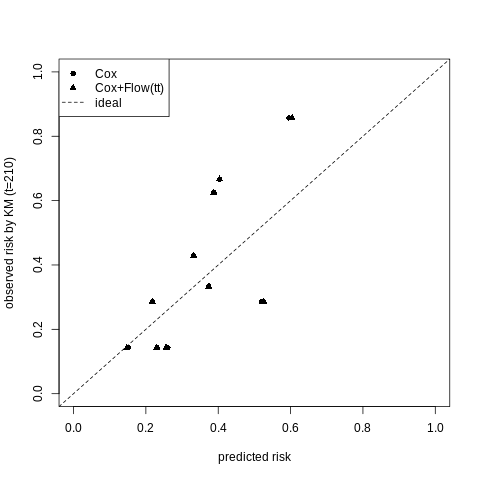

In [13]:
%%R
cal_curve <- function(p, time, event, t0, nbins=10){
  brk <- quantile(p, probs=seq(0,1,length.out=nbins+1), na.rm=TRUE)
  bin <- cut(p, breaks=brk, include.lowest=TRUE, labels=FALSE)
  out <- data.frame(bin=1:nbins, p_hat=NA, obs=NA, n=NA)
  for (b in 1:nbins){
    idx <- which(bin==b)
    out$n[b] <- length(idx)
    out$p_hat[b] <- mean(p[idx])
    if (length(idx)>=5){
      sf <- survfit(Surv(time[idx], event[idx]) ~ 1)
      s0 <- summary(sf, times=t0, extend=TRUE)$surv
      out$obs[b] <- 1 - s0
    }
  }
  out
}

test <- res_lung$test
t0 <- res_lung$times[2]  # 例：中央値時点
p0 <- as.numeric(res_lung$r0[,2])
p1 <- as.numeric(res_lung$r1[,2])

cc0 <- cal_curve(p0, test$time, test$event, t0)
cc1 <- cal_curve(p1, test$time, test$event, t0)

plot(cc0$p_hat, cc0$obs, xlim=c(0,1), ylim=c(0,1),
     xlab="predicted risk", ylab=paste0("observed risk by KM (t=", t0, ")"),
     pch=16)
abline(0,1,lty=2)
points(cc1$p_hat, cc1$obs, pch=17)
legend("topleft", legend=c("Cox","Cox+Flow(tt)","ideal"), pch=c(16,17,NA), lty=c(NA,NA,2))


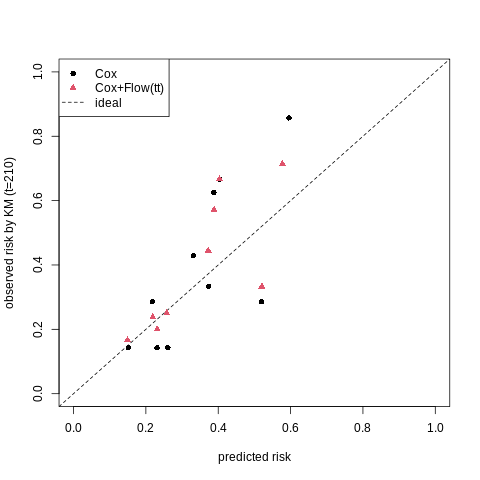

In [14]:
%%R
cal_curve_fixed <- function(p, time, event, t0, brk){
  bin <- cut(p, breaks=brk, include.lowest=TRUE, labels=FALSE)
  nbins <- length(brk) - 1
  out <- data.frame(bin=1:nbins, p_hat=NA, obs=NA, n=NA)
  for (b in 1:nbins){
    idx <- which(bin==b)
    out$n[b] <- length(idx)
    out$p_hat[b] <- mean(p[idx])
    if (length(idx)>=5){
      sf <- survfit(Surv(time[idx], event[idx]) ~ 1)
      s0 <- summary(sf, times=t0, extend=TRUE)$surv
      out$obs[b] <- 1 - s0
    }
  }
  out
}

test <- res_lung$test
t0   <- res_lung$times[2]
p0 <- as.numeric(res_lung$r0[,2])   # Cox
p1 <- as.numeric(res_lung$r1[,2])   # Cox+Flow(tt)

# ★ Cox の予測でビン境界を固定
brk <- quantile(p0, probs=seq(0,1,length.out=11), na.rm=TRUE)

cc0 <- cal_curve_fixed(p0, test$time, test$event, t0, brk)
cc1 <- cal_curve_fixed(p1, test$time, test$event, t0, brk)

plot(cc0$p_hat, cc0$obs, xlim=c(0,1), ylim=c(0,1),
     xlab="predicted risk", ylab=paste0("observed risk by KM (t=", t0, ")"),
     pch=16)
abline(0,1,lty=2)
points(cc1$p_hat, cc1$obs, pch=17, col=2)
legend("topleft", legend=c("Cox","Cox+Flow(tt)","ideal"),
       pch=c(16,17,NA), col=c(1,2,1), lty=c(NA,NA,2))


In [15]:
%%R
library(survival)

# -----------------------------
# utilities
# -----------------------------
make_event01 <- function(status){
  u <- sort(unique(na.omit(status)))
  if (all(u %in% c(0,1))) return(as.integer(status==1))
  if (all(u %in% c(1,2))) return(as.integer(status==2))
  return(as.integer(status==max(u)))
}

# IPCW weight for event-by-t0 loss
ipcw_weights_event <- function(time, event, t0){
  cens <- as.integer(event==0)
  fitG <- survfit(Surv(time, cens) ~ 1)

  Ghat <- function(u){
    s <- summary(fitG, times=u, extend=TRUE)$surv
    pmax(s, 1e-6)
  }

  y <- as.integer(event==1 & time <= t0)
  w <- ifelse(time <= t0, y / Ghat(time), 1 / Ghat(t0))
  list(y=y, w=w)
}

brier_ipcw <- function(p, y, w){
  mean(w * (y - p)^2)
}

# calibration curve with FIXED bins
cal_curve_fixed <- function(p, time, event, t0, brk){
  bin <- cut(p, breaks=brk, include.lowest=TRUE, labels=FALSE)
  nbins <- length(brk) - 1
  out <- data.frame(bin=1:nbins, p_hat=NA, obs=NA, n=NA)
  for (b in 1:nbins){
    idx <- which(bin==b)
    out$n[b] <- length(idx)
    out$p_hat[b] <- mean(p[idx])
    if (length(idx)>=5){
      sf <- survfit(Surv(time[idx], event[idx]) ~ 1)
      s0 <- summary(sf, times=t0, extend=TRUE)$surv
      out$obs[b] <- 1 - s0
    }
  }
  out
}

plot_calibration_pair <- function(res, name, j=2, nbins=10, col_flow="red3"){
  test <- res$test
  t0 <- res$times[j]
  p0 <- as.numeric(res$r0[,j])  # Cox risk
  p1 <- as.numeric(res$r1[,j])  # Cox+Flow risk

  brk <- quantile(p0, probs=seq(0,1,length.out=nbins+1), na.rm=TRUE)

  cc0 <- cal_curve_fixed(p0, test$time, test$event, t0, brk)
  cc1 <- cal_curve_fixed(p1, test$time, test$event, t0, brk)

  plot(cc0$p_hat, cc0$obs, xlim=c(0,1), ylim=c(0,1),
       xlab="predicted risk", ylab=paste0("observed risk by KM (t=", t0, ")"),
       pch=16, main=paste0(name, "  (t=", t0, ")"))
  abline(0,1,lty=2)
  points(cc1$p_hat, cc1$obs, pch=17, col=col_flow)
  legend("topleft", legend=c("Cox","Cox+Flow(tt)","ideal"),
         pch=c(16,17,NA), col=c(1,col_flow,1), lty=c(NA,NA,2), bty="n")
}

# -----------------------------
# Breslow (constant Cox)
# -----------------------------
breslow_const <- function(fit, train){
  tgrid <- sort(unique(train$time[train$event==1]))
  dk <- vapply(tgrid, function(t) sum(train$event==1 & train$time==t), numeric(1))

  lp_tr <- as.numeric(predict(fit, newdata=train, type="lp"))
  exp_lp_tr <- exp(lp_tr)

  risk_sum <- vapply(tgrid, function(t){
    sum(exp_lp_tr[train$time >= t])
  }, numeric(1))

  dH0 <- dk / pmax(risk_sum, 1e-12)
  list(tgrid=tgrid, dH0=dH0)
}

predict_risk_const <- function(fit, bh, newdata, times){
  lp <- as.numeric(predict(fit, newdata=newdata, type="lp"))
  exp_lp <- exp(lp)
  tgrid <- bh$tgrid; dH0 <- bh$dH0

  out <- sapply(times, function(t0){
    m <- findInterval(t0, tgrid)
    H0 <- if (m==0) 0 else sum(dH0[1:m])
    1 - exp(-exp_lp * H0)
  })
  colnames(out) <- paste0("t", times)
  out
}

# -----------------------------
# Breslow (tt: x * log t)
# -----------------------------
breslow_tt_log <- function(fit0, fit1, tv_var, train){
  cn <- names(coef(fit1))
  gname <- paste0("tt(", tv_var, ")")
  if (!(gname %in% cn)) stop("tt coefficient name not found: ", gname)

  gamma <- as.numeric(coef(fit1)[gname])

  Xtr <- model.matrix(fit0, data=train)
  beta_names <- intersect(colnames(Xtr), names(coef(fit1)))
  lp0_tr <- as.numeric(Xtr[, beta_names, drop=FALSE] %*% coef(fit1)[beta_names])

  x_tv <- as.numeric(train[[tv_var]])
  z_tr <- gamma * x_tv

  tgrid <- sort(unique(train$time[train$event==1]))
  dk <- vapply(tgrid, function(t) sum(train$event==1 & train$time==t), numeric(1))

  risk_sum <- vapply(tgrid, function(t){
    at_risk <- (train$time >= t)
    sum(exp(lp0_tr[at_risk] + z_tr[at_risk]*log(pmax(t,1e-12))))
  }, numeric(1))

  dH0 <- dk / pmax(risk_sum, 1e-12)
  list(tgrid=tgrid, dH0=dH0, gamma=gamma, beta_names=beta_names)
}

predict_risk_tt_log <- function(fit0, fit1, bh_tt, tv_var, newdata, times){
  Xnew <- model.matrix(fit0, data=newdata)
  beta_names <- bh_tt$beta_names
  lp0_new <- if (length(beta_names)==0) rep(0, nrow(Xnew)) else
    as.numeric(Xnew[, beta_names, drop=FALSE] %*% coef(fit1)[beta_names])

  z_new <- bh_tt$gamma * as.numeric(newdata[[tv_var]])

  tgrid <- bh_tt$tgrid; dH0 <- bh_tt$dH0
  logt <- log(pmax(tgrid, 1e-12))
  n <- nrow(Xnew)

  out <- sapply(times, function(t0){
    m <- findInterval(t0, tgrid)
    if (m==0) return(rep(0, n))
    w  <- dH0[1:m]
    lt <- logt[1:m]
    A <- as.vector(exp(outer(z_new, lt)) %*% matrix(w, ncol=1))
    H <- exp(lp0_new) * A
    1 - exp(-H)
  })
  colnames(out) <- paste0("t", times)
  out
}

# -----------------------------
# main runner
# -----------------------------
run_one <- function(df, time_col, status_col, x_formula, name="data"){
  rhs <- paste(deparse(x_formula), collapse="")
  rhs <- sub("^~\\s*", "", rhs)

  df <- df[, c(time_col, status_col, all.vars(as.formula(paste("~", rhs)))), drop=FALSE]
  df <- na.omit(df)
  df$time  <- df[[time_col]]
  df$event <- make_event01(df[[status_col]])

  set.seed(1)
  n <- nrow(df)
  idx <- sample.int(n, size=floor(0.7*n))
  train <- df[idx,]
  test  <- df[-idx,]

  f0 <- as.formula(paste0("Surv(time,event) ~ ", rhs))
  fit0 <- coxph(f0, data=train, x=TRUE, y=TRUE)

  zph <- cox.zph(fit0, transform="km")
  ptab <- zph$table
  pvec <- ptab[rownames(ptab)!="GLOBAL", "p"]

  cand <- intersect(names(pvec), names(train))
  cand <- cand[sapply(cand, function(v) is.numeric(train[[v]]))]
  if (length(cand)==0) stop("No numeric covariate available for tt().")
  tv_var <- cand[which.min(pvec[cand])]

  cat("\n========================\n")
  cat("Dataset:", name, "\n")
  cat("PH global p =", ptab["GLOBAL","p"], "\n")
  cat("Worst PH numeric var =", tv_var, " (p=", pvec[tv_var], ")\n")

  f1 <- update(f0, as.formula(paste0(". ~ . + tt(", tv_var, ")")))
  fit1 <- coxph(f1, data=train, x=TRUE, y=TRUE,
                tt=function(x,t,...) x*log(pmax(t,1e-12)))

  te <- test$time[test$event==1]
  times <- as.numeric(quantile(te, probs=c(0.25,0.5,0.75)))
  times <- sort(unique(times))

  bh0 <- breslow_const(fit0, train)
  r0  <- predict_risk_const(fit0, bh0, test, times)

  bh1 <- breslow_tt_log(fit0, fit1, tv_var, train)
  r1  <- predict_risk_tt_log(fit0, fit1, bh1, tv_var, test, times)

  diff_mean <- colMeans(abs(r1-r0))
  cat("Mean |risk_flow - risk_cox|:\n")
  print(data.frame(time=times, mean_abs_diff=diff_mean))

  list(train=train, test=test, fit0=fit0, fit1=fit1, zph=zph, times=times, tv_var=tv_var,
       r0=r0, r1=r1, name=name)
}

# -----------------------------
# data
# -----------------------------
lung <- survival::lung
pbc  <- survival::pbc
veteran <- tryCatch(survival::veteran, error=function(e) NULL)
if (is.null(veteran)) {
  if (!requireNamespace("cancer", quietly=TRUE)) install.packages("cancer")
  veteran <- cancer::veteran
}

# -----------------------------
# fit
# -----------------------------
res_lung <- run_one(lung, "time", "status", ~ age + sex + ph.ecog, "lung")
res_pbc  <- run_one(pbc,  "time", "status", ~ age + sex + bili + albumin + edema, "pbc")
res_vet  <- run_one(veteran,"time","status",~ trt + celltype + karno + diagtime + age, "veteran")

# -----------------------------
# summary table (IPCW-Brier at median time)
# -----------------------------
summ_one <- function(res, j=2){
  test <- res$test
  t0 <- res$times[j]
  p0 <- as.numeric(res$r0[,j])
  p1 <- as.numeric(res$r1[,j])
  ww <- ipcw_weights_event(test$time, test$event, t0)
  b0 <- brier_ipcw(p0, ww$y, ww$w)
  b1 <- brier_ipcw(p1, ww$y, ww$w)
  data.frame(
    dataset=res$name,
    t0=t0,
    PH_global_p=res$zph$table["GLOBAL","p"],
    tv_var=res$tv_var,
    mean_abs_diff=mean(abs(p1-p0)),
    brier_cox=b0,
    brier_flow=b1,
    brier_improve=b0-b1
  )
}
tab <- rbind(summ_one(res_lung), summ_one(res_pbc), summ_one(res_vet))
print(tab)
write.csv(tab, "summary_ph_vs_flow.csv", row.names=FALSE)
cat("\nWrote: summary_ph_vs_flow.csv\n")

# -----------------------------
# figures (3 panels) + save
# -----------------------------
png("Calib_3datasets_tMedian.png", width=1200, height=400)
par(mfrow=c(1,3), mar=c(4,4,3,1))
plot_calibration_pair(res_lung, "lung", j=2, nbins=10, col_flow="red3")
plot_calibration_pair(res_pbc,  "pbc",  j=2, nbins=10, col_flow="red3")
plot_calibration_pair(res_vet,  "veteran", j=2, nbins=10, col_flow="red3")
dev.off()
cat("Saved: Calib_3datasets_tMedian.png\n")



Dataset: lung 
PH global p = 0.5446495 
Worst PH numeric var = ph.ecog  (p= 0.2218851 )
Mean |risk_flow - risk_cox|:
     time mean_abs_diff
t144  144   0.004395462
t210  210   0.003482111
t351  351   0.001158296

Dataset: pbc 
PH global p = 0.1178333 
Worst PH numeric var = bili  (p= 0.04268011 )
Mean |risk_flow - risk_cox|:
           time mean_abs_diff
t501.25  501.25   0.015308931
t1180.5 1180.50   0.003407198
t2232   2232.00   0.006970961

Dataset: veteran 
PH global p = 0.0002172258 
Worst PH numeric var = karno  (p= 0.01891675 )
Mean |risk_flow - risk_cox|:
          time mean_abs_diff
t29.25   29.25    0.03592145
t93.5    93.50    0.01807314
t144.75 144.75    0.01929509
  dataset     t0  PH_global_p  tv_var mean_abs_diff  brier_cox brier_flow
1    lung  210.0 0.5446494670 ph.ecog   0.003482111 0.21586974 0.21577591
2     pbc 1180.5 0.1178333087    bili   0.003407198 0.06762801 0.06827837
3 veteran   93.5 0.0002172258   karno   0.018073144 0.16758229 0.16475616
  brier_improve


In [16]:
%%R
# ---- prerequisites ----
stopifnot(exists("res_lung"), exists("res_pbc"), exists("res_vet"))

# ---- read summary and choose PH-good / PH-bad ----
tab <- read.csv("summary_ph_vs_flow.csv")
print(tab)

good <- tab$dataset[which.max(tab$PH_global_p)]
bad  <- tab$dataset[which.min(tab$PH_global_p)]
cat("\nRecommended PH-good =", good, " | PH-bad =", bad, "\n")

res_map <- list(lung=res_lung, pbc=res_pbc, veteran=res_vet)

# ---- helpers: calibration with fixed bins + n labels ----
cal_curve_fixed <- function(p, time, event, t0, brk){
  bin <- cut(p, breaks=brk, include.lowest=TRUE, labels=FALSE)
  nbins <- length(brk) - 1
  out <- data.frame(bin=1:nbins, p_hat=NA_real_, obs=NA_real_, n=NA_integer_)
  for (b in 1:nbins){
    idx <- which(bin==b)
    out$n[b] <- length(idx)
    out$p_hat[b] <- mean(p[idx])
    if (length(idx) >= 5){
      sf <- survfit(Surv(time[idx], event[idx]) ~ 1)
      s0 <- summary(sf, times=t0, extend=TRUE)$surv
      out$obs[b] <- 1 - s0
    }
  }
  out
}

plot_calibration_pair_n <- function(res, name, j=2, nbins=10, col_flow="red3",
                                    cex_n=0.65, dx=0.015, dy=0.015){
  test <- res$test
  t0 <- res$times[j]
  p0 <- as.numeric(res$r0[,j])  # Cox
  p1 <- as.numeric(res$r1[,j])  # Cox+Flow(tt)

  # bin edges fixed by Cox prediction
  brk <- quantile(p0, probs=seq(0,1,length.out=nbins+1), na.rm=TRUE)

  cc0 <- cal_curve_fixed(p0, test$time, test$event, t0, brk)
  cc1 <- cal_curve_fixed(p1, test$time, test$event, t0, brk)

  plot(cc0$p_hat, cc0$obs, xlim=c(0,1), ylim=c(0,1),
       xlab="predicted risk", ylab=paste0("observed risk by KM (t=", t0, ")"),
       pch=16, main=paste0(name, "  (t=", t0, ")"))
  abline(0,1,lty=2)

  points(cc1$p_hat, cc1$obs, pch=17, col=col_flow)

  # n labels (only where obs is available)
  ok <- which(!is.na(cc0$obs))
  text(cc0$p_hat[ok] + dx, cc0$obs[ok] + dy,
       labels=paste0("n=", cc0$n[ok]), cex=cex_n, col="gray30")

  legend("topleft", legend=c("Cox","Cox+Flow(tt)","ideal"),
         pch=c(16,17,NA), col=c(1,col_flow,1), lty=c(NA,NA,2), bty="n")
}

# ---- recommended bin counts (stabilize pbc/veteran) ----
nbins_lung <- 10
nbins_pbc  <- 5
nbins_vet  <- 5

# ---- 3-panel (book-friendly) high-res PNG ----
png("Calib_3datasets_tMedian_300dpi.png", width=12, height=4, units="in", res=300, pointsize=10)
par(mfrow=c(1,3), mar=c(4,4,3,1))
plot_calibration_pair_n(res_lung, "lung",   j=2, nbins=nbins_lung)
plot_calibration_pair_n(res_pbc,  "pbc",    j=2, nbins=nbins_pbc)
plot_calibration_pair_n(res_vet,  "veteran",j=2, nbins=nbins_vet)
dev.off()
cat("Saved: Calib_3datasets_tMedian_300dpi.png\n")

# ---- 2-panel (PH-good vs PH-bad) high-res PNG ----
pick_nbins <- function(ds){
  if (ds=="lung") return(nbins_lung)
  if (ds=="pbc") return(nbins_pbc)
  return(nbins_vet)
}

png("Calib_PHgood_vs_PHbad_300dpi.png", width=8, height=4, units="in", res=300, pointsize=10)
par(mfrow=c(1,2), mar=c(4,4,3,1))
plot_calibration_pair_n(res_map[[good]], good, j=2, nbins=pick_nbins(good))
plot_calibration_pair_n(res_map[[bad]],  bad,  j=2, nbins=pick_nbins(bad))
dev.off()
cat("Saved: Calib_PHgood_vs_PHbad_300dpi.png\n")


  dataset     t0  PH_global_p  tv_var mean_abs_diff  brier_cox brier_flow
1    lung  210.0 0.5446494670 ph.ecog   0.003482111 0.21586974 0.21577591
2     pbc 1180.5 0.1178333087    bili   0.003407198 0.06762801 0.06827837
3 veteran   93.5 0.0002172258   karno   0.018073144 0.16758229 0.16475616
  brier_improve
1  9.383417e-05
2 -6.503642e-04
3  2.826132e-03

Recommended PH-good = lung  | PH-bad = veteran 
Saved: Calib_3datasets_tMedian_300dpi.png
Saved: Calib_PHgood_vs_PHbad_300dpi.png
